# WHO Life Expectancy Predictive Model

## Contents
- Importing Modules
- Defining Functions
- Taking user input
- Feature Engineering
- Model Creation
- Model Evaluation

## Importing Modules

In [4]:
#importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tools
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split

#import data
data = pd.read_csv("Life Expectancy Data.csv")


## Stepwise Selection Function

In [6]:
def stepwise_selection(X, y, threshold_in=0.01, threshold_out=0.05, verbose=False):
    included = []  # This is going to be the list of features we keep
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        # We add the feature with the lowest (best) p-value under the threshold to our 'included' list
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # Backward step: removing features if new features added to the list make them statistically insignificant
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        
        # Use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # Null if pvalues is empty
        # If the p-value exceeds the upper threshold, the feature will be dropped from the 'included' list
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return model, included


## Interactive Data Input For Prediction

In [8]:
def ask_for_consent():
    response = input("Do you consent to using advanced population data, which may include protected information, for better accuracy? (Yes/No): ")
    
    if response.strip().lower() == 'yes':
        print("Thank you for your consent.")
        return True
    elif response.strip().lower() == 'no':
        print("You did not give consent.")
        return False
    else:
        print("Invalid response. Please enter 'Yes' or 'No'.")
        return ask_for_consent()

def ask_for_year_range():
    try:
        year = int(input("Enter the year you wish to predict (between 2000 and 2025): "))
        
        if 2000 <= year <= 2025:
            print(f"You have selected the year: {year}")
            return year
        else:
            print("Invalid range. Please ensure the year is between 2000 and 2025.")
            return ask_for_year_range()
    except ValueError:
        print("Invalid input. Please enter a valid year.")
        return ask_for_year_range()

def ask_for_region():
    region_prompt = (
        "What region is the country you are investigating? Please type:\n"
        "1 for Africa\n"
        "2 for Asia\n"
        "3 for Central America and Caribbean\n"
        "4 for European Union\n"
        "5 for Middle East\n"
        "6 for North America\n"
        "7 for Oceania\n"
        "8 for Rest of Europe\n"
        "9 for South America\n"
        "(range 1 to 9): "
    )
    try:
        region = int(input(region_prompt))
        if 1 <= region <= 9:
            region_names = {
                1: "Africa",
                2: "Asia",
                3: "Central America and Caribbean",
                4: "European Union",
                5: "Middle East",
                6: "North America",
                7: "Oceania",
                8: "Rest of Europe",
                9: "South America"
            }
            print(f"You have selected: {region_names[region]}")
            return region
        else:
            print("Invalid choice. Please select a number between 1 and 9.")
            return ask_for_region()
    except ValueError:
        print("Invalid input. Please enter a number between 1 and 9.")
        return ask_for_region()

def get_population():
    while True:
        try:
            population = float(input("What is the population of the country in millions? "))
            if 0 <= population <= 1500:
                return population
            else:
                print("Please enter a number between 0 and 1500.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_gdp_per_capita():
    while True:
        try:
            gdp_per_capita = float(input("What is the GDP per capita of the country in USD ($)? "))
            if 100 <= gdp_per_capita <= 150000:
                return gdp_per_capita
            else:
                print("Please enter a number between 100 and 150000.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def ask_for_economy_status():
    while True:
        response = input("Does the country have a developed economy? (Yes/No): ").strip().lower()
        if response == 'yes':
            print("The country has a developed economy.")
            return True
        elif response == 'no':
            print("The country has an undeveloped economy.")
            return False
        else:
            print("Invalid response. Please enter 'yes' or 'no'.")

def get_infant_deaths():
    while True:
        try:
            infant_deaths = float(input("What are the number of infant deaths per 1000 population of the country? "))
            if 0 <= infant_deaths <= 200:
                return infant_deaths
            else:
                print("Please enter a number between 0 and 200.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_under_five_deaths():
    while True:
        try:
            under_five_deaths = float(input("What are the number of under-five deaths per 1000 population of the country? "))
            if 0 <= under_five_deaths <= 225:
                return under_five_deaths
            else:
                print("Please enter a number between 0 and 300.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_thinness_10_to_19():
    while True:
        try:
            thinness_10_to_19 = float(input("What is the prevalence (%) of thinness between the ages of 10 to 19 years in the country? "))
            if 0 <= thinness_10_to_19 <= 30:
                return thinness_10_to_19
            else:
                print("Please enter a percentage between 0 and 50.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_thinness_5_to_9():
    while True:
        try:
            thinness_5_to_9 = float(input("What is the prevalence (%) of thinness between the ages of 5 to 9 years in the country? "))
            if 0 <= thinness_5_to_9 <= 30:
                return thinness_5_to_9
            else:
                print("Please enter a percentage between 0 and 50.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_years_of_schooling():
    while True:
        try:
            years_of_schooling = float(input("What are the average number of years of schooling in the country? "))
            if 1 <= years_of_schooling <= 15:
                return years_of_schooling
            else:
                print("Please enter a number between 1 and 15.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_adult_mortality():
    while True:
        try:
            adult_mortality = float(input("What is the combined adult mortality rates of men and women between 15 and 60 years per 1000 population of the country? "))
            if 49 <= adult_mortality <= 800:
                return adult_mortality
            else:
                print("Please enter a number between 49 and 800.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_alcohol_consumption():
    while True:
        try:
            alcohol_consumption = float(input("What is the alcohol consumption, measured in litres of pure alcohol per person of 15 years of age or older, in the country (litres)? "))
            if 0 <= alcohol_consumption <= 20:
                return alcohol_consumption
            else:
                print("Please enter a number between 0 and 20.")
        except ValueError:
            print("Invalid input. Please enter a float.")

def get_hepb_coverage():
    while True:
        try:
            hepb_coverage = float(input("What is the percentage of one-year-olds who have received the Hepatitis B (HepB) immunization coverage in a given year in the country (%)? "))
            if 0 <= hepb_coverage <= 100:
                return hepb_coverage
            else:
                print("Please enter a number between 0 and 100.")
        except ValueError:
            print("Invalid input. Please enter an number.")

def get_measles_cases():
    while True:
        try:
            measles_cases = float(input("What is the number of reported cases of measles per 1000 population in the country? "))
            if 10 <= measles_cases <= 100:
                return measles_cases
            else:
                print("Please enter a number between 0 and 200.")
        except ValueError:
            print("Invalid input. Please enter an number.")

def get_bmi():
    while True:
        try:
            bmi = float(input("What is the average Body Mass Index (BMI) in the country? "))
            if 19 <= bmi <= 33:
                return bmi
            else:
                print("Please enter a number between 18 and 35.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def get_polio_coverage():
    while True:
        try:
            polio_coverage = float(input("What is the percentage of one-year-olds who have received the Polio (Pol3) immunization coverage in a given year in the country (%)? "))
            if 0 <= polio_coverage <= 100:
                return polio_coverage
            else:
                print("Please enter a number between 0 and 100.")
        except ValueError:
            print("Invalid input. Please enter an number.")

def get_dtp3_coverage():
    while True:
        try:
            dtp3_coverage = float(input("What is the percentage of one-year-olds who have received the Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage in a given year in the country (%)? "))
            if 0 <= dtp3_coverage <= 100:
                return dtp3_coverage
            else:
                print("Please enter a number between 0 and 100.")
        except ValueError:
            print("Invalid input. Please enter an number.")

def main():
    consent_given = ask_for_consent()
    if consent_given:
        year_range = ask_for_year_range()
        region = ask_for_region()
        population = get_population()
        gdp_per_capita = get_gdp_per_capita()
        economy_status = ask_for_economy_status()
        infant_deaths = get_infant_deaths()
        under_five_deaths = get_under_five_deaths()
        thinness_10_to_19 = get_thinness_10_to_19()
        thinness_5_to_9 = get_thinness_5_to_9()
        years_of_schooling = get_years_of_schooling()
        adult_mortality = get_adult_mortality()
        alcohol_consumption = get_alcohol_consumption()
        hepb_coverage = get_hepb_coverage()
        measles_cases = get_measles_cases()
        bmi = get_bmi()
        polio_coverage = get_polio_coverage()
        dtp3_coverage = get_dtp3_coverage()
        
        # Create a dictionary with the input data
        input_data = {
            'Year': year_range,
            'Population_mln': population,
            'GDP_per_capita': gdp_per_capita,
            'Economy_status_Developed': 1 if economy_status else 0,
            'Infant_deaths': infant_deaths,
            'Under_five_deaths': under_five_deaths,
            'Thinness_ten_nineteen_years': thinness_10_to_19,
            'Thinness_five_nine_years': thinness_5_to_9,
            'Schooling': years_of_schooling,
            'Adult_mortality': adult_mortality,
            'Alcohol_consumption': alcohol_consumption,
            'Hepatitis_B': hepb_coverage,
            'Measles': measles_cases,
            'BMI': bmi,
            'Polio': polio_coverage,
            'Diphtheria': dtp3_coverage
        }
        
        
            # One-hot encode the region and merge with the input data
        regions = ["Africa", "Asia", "Central America and Caribbean", "European Union", "Middle East", "North America", "Oceania", "Rest of Europe", "South America"]
        # One-hot encode the region and merge with the input data
        region_encoded = pd.get_dummies([region], prefix='Region').reindex(columns=[f'Region_{r}' for r in regions], fill_value=0)

        # Convert input data to DataFrame and concatenate with encoded region
        input_df = pd.DataFrame([input_data])
        user_input_df = pd.concat([input_df, region_encoded], axis=1)

        # Ensure the columns match the training data
        model_columns = ['Year',
            'Population_mln',
            'GDP_per_capita',
            'Economy_status_Developed',
            'Infant_deaths',
            'Under_five_deaths',
            'Thinness_ten_nineteen_years',
            'Thinness_five_nine_years',
            'Schooling',
            'Adult_mortality',
            'Alcohol_consumption',
            'Hepatitis_B',
            'Measles',
            'BMI',
            'Polio',
            'Diphtheria'] + [f'Region__{r}' for r in regions]

        # Reindex to ensure all necessary columns are present
        user_input_df = user_input_df.reindex(columns=model_columns, fill_value=0)
            # Create a DataFrame from the collected data
        user_input = pd.DataFrame(user_input_df)
            # Additional code to handle the given data can go here
        print(f"Year: {year_range}, Region: {region}, Population: {population} million, GDP per capita: ${gdp_per_capita}, Developed economy: {'Yes' if economy_status else 'No'}, Infant deaths per 1000: {infant_deaths}, Under-five deaths per 1000: {under_five_deaths}, Thinness 10-19: {thinness_10_to_19}%, Thinness 5-9: {thinness_5_to_9}%, Years of schooling: {years_of_schooling}, Adult mortality: {adult_mortality}, Alcohol consumption: {alcohol_consumption} litres, HepB coverage: {hepb_coverage}%, Measles cases per 1000: {measles_cases}, Average BMI: {bmi}, Polio coverage: {polio_coverage}%, DTP3 coverage: {dtp3_coverage}%")

        return consent_given, user_input
    elif consent_given == False:
        year_range = ask_for_year_range()
        population = get_population()
        gdp_per_capita = get_gdp_per_capita()
        economy_status = ask_for_economy_status()
        infant_deaths = get_infant_deaths()
        under_five_deaths = get_under_five_deaths()
        thinness_10_to_19 = get_thinness_10_to_19()
        thinness_5_to_9 = get_thinness_5_to_9()
        years_of_schooling = get_years_of_schooling()
        adult_mortality = get_adult_mortality()
        alcohol_consumption = get_alcohol_consumption()
        hepb_coverage = get_hepb_coverage()
        measles_cases = get_measles_cases()
        bmi = get_bmi()
        polio_coverage = get_polio_coverage()
        dtp3_coverage = get_dtp3_coverage()
        
        # Create a dictionary with the input data
        input_data = {
            'Year': year_range,
            'Population_mln': population,
            'GDP_per_capita': gdp_per_capita,
            'Economy_status_Developed': 1 if economy_status else 0,
            'Infant_deaths': infant_deaths,
            'Under_five_deaths': under_five_deaths,
            'Thinness_ten_nineteen_years': thinness_10_to_19,
            'Thinness_five_nine_years': thinness_5_to_9,
            'Schooling': years_of_schooling,
            'Adult_mortality': adult_mortality,
            'Alcohol_consumption': alcohol_consumption,
            'Hepatitis_B': hepb_coverage,
            'Measles': measles_cases,
            'BMI': bmi,
            'Polio': polio_coverage,
            'Diphtheria': dtp3_coverage
        }
          
        # Convert input data to DataFrame and concatenate
        input_df = pd.DataFrame([input_data])

    else:
        print("Please give a valid answer.")
        main()
    return consent_given, input_df
if __name__ == "__main__":
    consent, user = main()

        


Do you consent to using advanced population data, which may include protected information, for better accuracy? (Yes/No):  y


Invalid response. Please enter 'Yes' or 'No'.


Do you consent to using advanced population data, which may include protected information, for better accuracy? (Yes/No):  21


Invalid response. Please enter 'Yes' or 'No'.


Do you consent to using advanced population data, which may include protected information, for better accuracy? (Yes/No):  yes


Thank you for your consent.


Enter the year you wish to predict (between 2000 and 2025):  2020


You have selected the year: 2020


What region is the country you are investigating? Please type:
1 for Africa
2 for Asia
3 for Central America and Caribbean
4 for European Union
5 for Middle East
6 for North America
7 for Oceania
8 for Rest of Europe
9 for South America
(range 1 to 9):  4


You have selected: European Union


What is the population of the country in millions?  42
What is the GDP per capita of the country in USD ($)?  38000
Does the country have a developed economy? (Yes/No):  yes


The country has a developed economy.


What are the number of infant deaths per 1000 population of the country?  12
What are the number of under-five deaths per 1000 population of the country?  8
What is the prevalence (%) of thinness between the ages of 10 to 19 years in the country?  2
What is the prevalence (%) of thinness between the ages of 5 to 9 years in the country?  1
What are the average number of years of schooling in the country?  13
What is the combined adult mortality rates of men and women between 15 and 60 years per 1000 population of the country?  57
What is the alcohol consumption, measured in litres of pure alcohol per person of 15 years of age or older, in the country (litres)?  7
What is the percentage of one-year-olds who have received the Hepatitis B (HepB) immunization coverage in a given year in the country (%)?  67
What is the number of reported cases of measles per 1000 population in the country?  23
What is the average Body Mass Index (BMI) in the country?  27
What is the percentage of one-year-o

Year: 2020, Region: 4, Population: 42.0 million, GDP per capita: $38000.0, Developed economy: Yes, Infant deaths per 1000: 12.0, Under-five deaths per 1000: 8.0, Thinness 10-19: 2.0%, Thinness 5-9: 1.0%, Years of schooling: 13.0, Adult mortality: 57.0, Alcohol consumption: 7.0 litres, HepB coverage: 67.0%, Measles cases per 1000: 23.0, Average BMI: 27.0, Polio coverage: 89.0%, DTP3 coverage: 98.0%


## Feature Engineering

In [10]:
if consent == True:
    #some feature engineering - dropping columns, OHE
    new_data = data.drop(columns = ['Country', 'Economy_status_Developing', 'Incidents_HIV'])
    new_data = pd.get_dummies(new_data, columns = ['Region'], prefix = 'Region_', dtype=int)
elif consent == False:
    new_data = data.drop(columns=['Region', 'Country', 'Economy_status_Developing', 'Incidents_HIV'])


    
#splitting data into X and Y for the model
feature_cols = list(new_data.columns)
feature_cols.remove('Life_expectancy')
X = new_data[feature_cols]
y = new_data['Life_expectancy']

#log of GDP
X['log_GDP_per_capita'] = np.log(X['GDP_per_capita'])
X = X.drop(columns = 'GDP_per_capita')

#test train split for model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.375, random_state=42)

# Columns not to be scaled
columns_not_to_scale = ['log_GDP_per_capita', 'Economy_status_Developed', "Region__Africa", "Region__Asia", 
                        "Region__Central America and Caribbean", "Region__European Union", "Region__Middle East", 
                        "Region__North America", "Region__Oceania", "Region__Rest of Europe", "Region__South America"]

#dont scale binary data
columns_not_to_scale_present = [col for col in columns_not_to_scale if col in X_train.columns]
columns_to_scale = [col for col in X_train.columns if col not in columns_not_to_scale_present]

#initialize the scaler
scaler = StandardScaler()

#scale all relevant columns
X_train_scaled = X_train.copy()
X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

user_scaled = user.copy()
user_scaled['log_GDP_per_capita'] = np.log(user_scaled['GDP_per_capita'])
user_scaled = user_scaled.drop(columns = 'GDP_per_capita')
user_scaled[columns_to_scale] = scaler.transform(user[columns_to_scale])


## Creating the Model

In [12]:
#creating a model
result, selected_features = stepwise_selection(X_train_scaled, y_train)

## Prediction Result

In [14]:
user_selected = user_scaled[selected_features]


new_pred = result.predict(sm.add_constant(user_selected, has_constant = 'add')).round(1)
print(f'For the given data, the model predicts a life expectancy of: {new_pred.iloc[0]} years')

For the given data, the model predicts a life expectancy of: 80.9 years


## Model Evaluation

In [16]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     7336.
Date:                Wed, 29 May 2024   Prob (F-statistic):               0.00
Time:                        15:49:27   Log-Likelihood:                -2873.1
No. Observations:                1790   AIC:                             5778.
Df Residuals:                    1774   BIC:                             5866.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    64.2326      0.381    168.534      0.000      63.485      64.980
Adult_mortality                          -5.1693      0.054    -95.526      0.000      -5.275      -5.063
Under_five_deaths                        -2.1176      0.208    -10.192      0.000      -2.525      -1.710
Economy_status_Developed                  2.6580      0.178     14.953      0.000       2.309       3.007
log_GDP_per_capita                        0.4355      0.044      9.828      0.000       0.349       0.522
Region__Central America and Caribbean     1.8634      0.113     16.442      0.000       1.641       2.086
Region__South America                     1.6396      0.129     12.716      0.000       1.387       1.892
Region__Oceania                          -0.7592      0.145     -5.243      0.000      -1.043      -0.475
Region__European Union                   -0.7434      0.177     -4.209      0.000      -1.090      -0.397
Infant_deaths                            -1.4788      0.209     -7.070      0.000      -1.889      -1.069
Region__Asia                              0.4211      0.116      3.643      0.000       0.194       0.648
Year                                      0.1649      0.030      5.479      0.000       0.106       0.224
Region__Rest of Europe                    0.4696      0.143      3.273      0.001       0.188       0.751
BMI                                      -0.2904      0.053     -5.507      0.000      -0.394      -0.187
Schooling                                 0.2625      0.065      4.012      0.000       0.134       0.391
Region__North America                     0.8234      0.230      3.573      0.000       0.371       1.275
==============================================================================
Omnibus:                       13.108   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               13.386
Skew:                           0.187   Prob(JB):                      0.00124
Kurtosis:                       3.198   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Make predictions using the selected features
X_train_selected = X_train_scaled[selected_features]
y_pred = result.predict(sm.add_constant(X_train_selected))


# Calculate RMSE
rmse = statsmodels.tools.eval_measures.rmse(y_train, y_pred)
print(f'For the training set, the magnitude of the error is: {rmse.round(3)}')

For the training set, the magnitude of the error is: 1.205


In [18]:
# Filter X_test to include only the selected features
X_test_selected = X_test_scaled[selected_features]
y_test_pred = result.predict(sm.add_constant(X_test_selected))

# Calculate RMSE for the test set
test_rmse = statsmodels.tools.eval_measures.rmse(y_test, y_test_pred)
print(f'For the test set, the magnitude of the error is: {test_rmse.round(3)}')

For the test set, the magnitude of the error is: 1.191


D:\anaconda3\Lib\site-packages\statsmodels\graphics\regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)


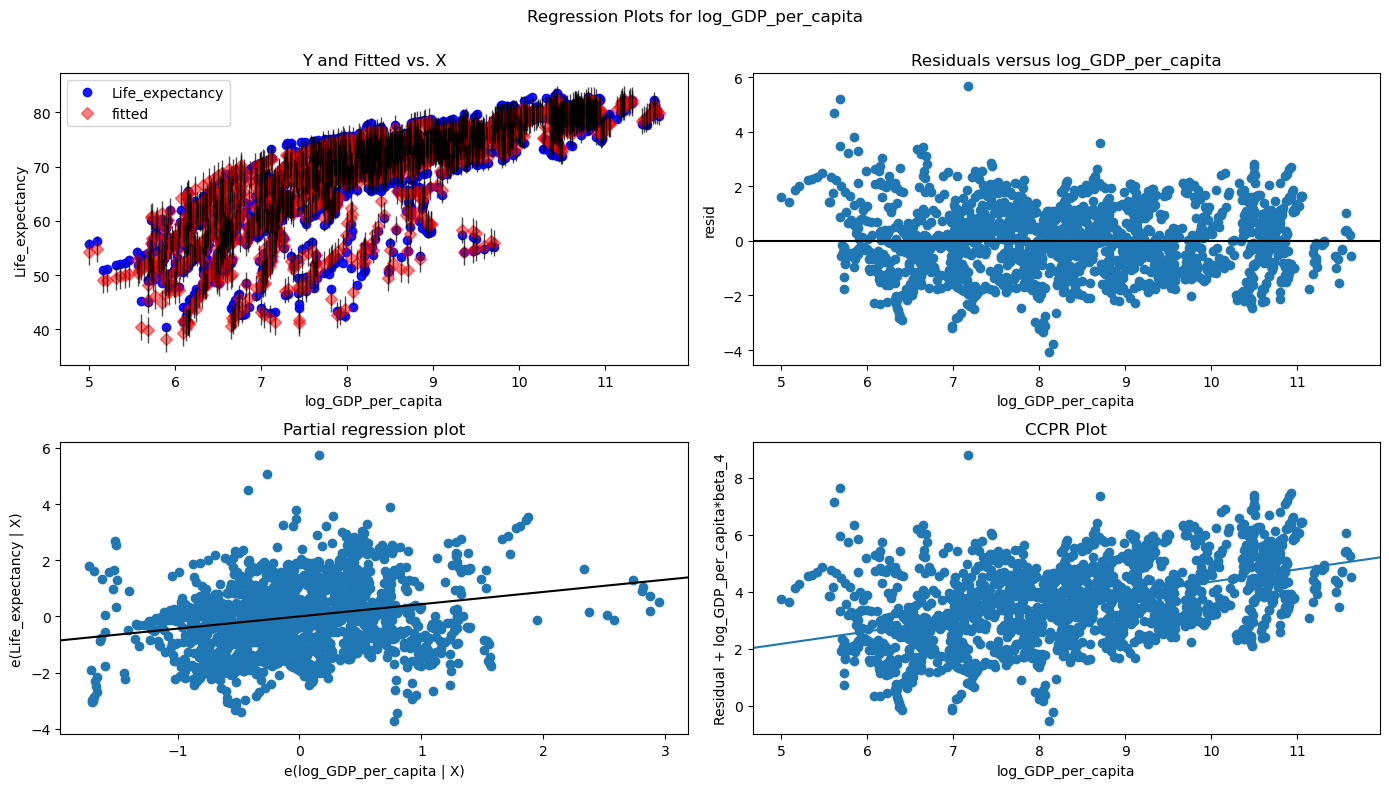

In [19]:
fig = plt.figure(figsize = (14, 8))
fig = sm.graphics.plot_regress_exog(result, 'log_GDP_per_capita', fig = fig)